In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [3]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def post(self, path, data):
        
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        l = ["return","nav"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        return self.post("portfolio/1827/dyn_amount_compo", data)
        

req = RESTManager()

In [4]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{"2016-06-01":[{"asset":{"asset":2024,"quantity":2.0}}]}}'

In [5]:
df_asset = req.get_asset()
df_asset

,ASSET PRICE MODE,ASSET_DATABASE_ID,ASSET_MARKET_SUB_GROUP,ASSET_OR_MARKET_PLACE_COUNTRY,ASSET_STATUS,BLOOMBERG_CODE,BLOOMBERG_ID,BOND_CREDIT_RISK_COMPUTATION_MODE,BOND_RISK_COMPUTATION_MODE,BOND_WAL_COMPUTATION_MODE,...,asset_fund_info_redemption_frequency,asset_fund_info_reuters_code,asset_fund_info_strategy,asset_fund_info_subscription_committee,asset_fund_info_subscription_frequency,asset_fund_info_valoren_code,asset_fund_info_valorisation_frequency,asset_fund_info_vl_date,asset_fund_info_vl_known,quote_value_type
0,Par Défaut (configuration),1845,NaN,Allemagne,normal,DRI GY EQUITY,BBG000BD8RR1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
1,Par Défaut (configuration),1846,Euronext Growth,France,normal,ALMIL FP EQUITY,BBG000M1HS93,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
2,Par Défaut (configuration),2122,NaN,France,normal,VEGCEQD FP EQUITY,BBG000NBHV66,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Blend,NaN,NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,NaN,Défaut
3,Par Défaut (configuration),2123,NaN,France,normal,SGPPEA2 FP EQUITY,BBG000Q6B219,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Blend,"0,01",NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,false,Défaut
4,Par Défaut (configuration),2124,NaN,France,normal,SGPRIV1 FP EQUITY,BBG000NFZ9R3,Par défaut,Par défaut,Par défaut,...,NaN,NaN,Moderate Allocation,NaN,NaN,NaN,Journalière,Journalière(Tous) - (Français (France)/0/Aucun...,false,Défaut
5,Par Défaut (configuration),1428,NaN,France,normal,AAACSII FP EQUITY,NaN,Par défaut,Par défaut,Par défaut,...,NaN,LP60099722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
6,Par Défaut (configuration),1847,Reg. Mkt - Segment A,Pays-Bas,normal,AALB NA EQUITY,BBG001V72X75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
7,Par Défaut (configuration),1848,NaN,Allemagne,normal,ARL GY EQUITY,BBG000MT6Y82,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
8,Par Défaut (configuration),1849,Reg.Mkt - Segment B,France,normal,ABCA FP EQUITY,BBG005YV6GR1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Défaut
9,Par Défaut (configuration),2154,NaN,Luxembourg,normal,ABGCHA2 LX EQUITY,BBG000C22B04,Par défaut,Par défaut,Par défaut,...,Journalière,NaN,Blend,"0,0638",Journalière,NaN,Journalière,NaN,NaN,Défaut


In [6]:
df_asset[["ASSET_DATABASE_ID", "CURRENCY","MARKET_PLACE_CURRENCY", "TYPE"]]

,ASSET_DATABASE_ID,CURRENCY,MARKET_PLACE_CURRENCY,TYPE
0,1845,EUR,EUR,STOCK
1,1846,EUR,EUR,STOCK
2,2122,EUR,EUR,FUND
3,2123,EUR,EUR,FUND
4,2124,EUR,EUR,FUND
5,1428,EUR,EUR,FUND
6,1847,EUR,EUR,STOCK
7,1848,EUR,EUR,STOCK
8,1849,EUR,EUR,STOCK
9,2154,USD,EUR,FUND


In [7]:
print(req.get_asset_id("2122"))
print(req.get_asset_id("1845"))

{'REST_OBJECT_ID': '2122', 'REST_UNIQUE_NUMBER': '2122', 'LABEL': '1818-VEGA EUR CO', 'TYPE': 'FUND', 'CURRENCY': 'EUR', 'BLOOMBERG_CODE': 'VEGCEQD FP EQUITY', 'ISIN_CODE': 'FR0010626796', 'SUB_SECTOR': 'Instruments de placement hors actions', 'MARKET_PLACE': 'No Place', 'COUNTRY': 'France', 'IS_PUBLICLY_TRADED': 'true', 'ELIGIBLE_PEA': 'true', 'QUOTE_TYPE': 'value', 'IS_STRUCTURED_PRODUCT': 'false', 'IS_DEPOSITARY_QUOTES': 'false', 'IS_ACCESSIBILITY_PUBLIC': 'true', 'ASSET_STATUS': 'normal', 'CITY_OR_ACRONYM_OR_NAME': 'no_place', 'SUB_TYPE': 'OPCVM', 'TRANSPARENCY_LIST': '', 'CODE_CIC': 'XL41', 'BOND_RISK_COMPUTATION_MODE': 'Par défaut', 'LIQUIDITY_ALGO': 'PerVolLiquidityAlgorithm', 'BLOOMBERG_ID': 'BBG000NBHV66', 'quote_value_type': 'Défaut', 'ASSET PRICE MODE': 'Par Défaut (configuration)', 'PAY_ACCOUNT_ON_DEFAULT': 'false', 'ELIGIBLE_PEA_PME': 'true', 'ASSET_DATABASE_ID': '2122', 'EMIR_CLEARING_ID_TYPE': 'LEI', 'BOND_CREDIT_RISK_COMPUTATION_MODE': 'Par défaut', 'BOND_YTM_COMPUTATIO

In [8]:
req.get("ratio")

'[{"id":11,"type":"Ratio","name":"Correlation","is_benchmark_needed":true,"is_percent":false},{"id":7,"type":"Ratio","name":"Exposition action","is_benchmark_needed":false,"is_percent":true},{"id":15,"type":"Ratio","name":"Exposition action","is_benchmark_needed":false,"is_percent":true},{"id":8,"type":"Ratio","name":"RDT","is_benchmark_needed":false,"is_percent":true},{"id":13,"type":"Ratio","name":"Rendement","is_benchmark_needed":false,"is_percent":true},{"id":9,"type":"Ratio","name":"Rendement_annualise","is_benchmark_needed":false,"is_percent":true},{"id":12,"type":"Ratio","name":"Sharpe","is_benchmark_needed":false,"is_percent":false},{"id":14,"type":"Ratio","name":"VaR historique","is_benchmark_needed":false,"is_percent":true},{"id":10,"type":"Ratio","name":"Volatilite","is_benchmark_needed":false,"is_percent":true}]'

In [9]:
dt_text = req.get(f"asset/1845/quote")
dt = json.loads(dt_text)
pd.DataFrame(dt)
df = []
for i in range(len(dt)):
    tmp = {}
    for key in dt[i]:
        tmp[key] = dt[i][key]["value"]
    df.append(tmp)
df = pd.DataFrame(df)
df

,ask,asset,bid,close,date,feed_source,gross,high,low,nav,open,pl,real_close_price,return,volume
0,"12,58",1845,"12,58","12,585",2013-06-03,-10,"12,585","12,67","12,08","12,585","12,6",0,"12,585",0,742280
1,"12,67",1845,"12,59","12,67",2013-06-04,-10,"12,67","12,95","12,5","12,67","12,65","0,085","12,67","0,006754072308",544604
2,"12,37",1845,"12,295","12,35",2013-06-05,-10,"12,35","12,66","12,34","12,35","12,579","-0,32","12,35","-0,025256511444",649313
3,"12,37",1845,"12,355","12,355",2013-06-06,-10,"12,355","12,45","12,25","12,355","12,35","0,005","12,355","0,0004048583",371998
4,"12,555",1845,"12,475","12,48",2013-06-07,-10,"12,48","12,63","12,25","12,48","12,35","0,125","12,48","0,010117361392",303439
5,"12,495",1845,"12,415","12,43",2013-06-10,-10,"12,43","12,625","12,37","12,43","12,445","-0,05","12,43","-0,004006410256",210296
6,"12,445",1845,"12,38","12,405",2013-06-11,-10,"12,405","12,481","12,265","12,405","12,37","-0,025","12,405","-0,002011263073",285197
7,"12,325",1845,"12,3","12,3",2013-06-12,-10,"12,3","12,435","12,28","12,3","12,375","-0,105","12,3","-0,0084643289",310978
8,"12,125",1845,"12,05","12,01",2013-06-13,-10,"12,01","12,32","11,715","12,01","12,235","-0,29","12,01","-0,023577235772",1020589
9,"12,13",1845,"12,075","12,12",2013-06-14,-10,"12,12","12,17","12,01","12,12","12,01","0,11","12,12","0,009159034138",312048


In [85]:
dt_text = req.get(f"asset/2122/quote")
dt = json.loads(dt_text)
pd.DataFrame(dt)
df = []
for i in range(len(dt)):
    tmp = {}
    for key in dt[i]:
        tmp[key] = dt[i][key]["value"]
    df.append(tmp)
df = pd.DataFrame(df)
df

,asset,close,date,feed_source,gross,nav,pl,real_close_price,return
0,2122,"31,098",2013-06-03,-10,"31,098","31,098",0,"31,098",0
1,2122,"31,166",2013-06-04,-10,"31,166","31,166","0,068","31,166","0,002186635797"
2,2122,"30,793",2013-06-05,-10,"30,793","30,793","-0,373","30,793","-0,011968170442"
3,2122,"30,478",2013-06-06,-10,"30,478","30,478","-0,315","30,478","-0,010229597636"
4,2122,"30,909",2013-06-07,-10,"30,909","30,909","0,431","30,909","0,014141347857"
5,2122,"30,924",2013-06-10,-10,"30,924","30,924","0,015","30,924","0,000485295545"
6,2122,"30,492",2013-06-11,-10,"30,492","30,492","-0,432","30,492","-0,013969732247"
7,2122,"30,464",2013-06-12,-10,"30,464","30,464","-0,028","30,464","-0,000918273646"
8,2122,"30,384",2013-06-13,-10,"30,384","30,384","-0,08","30,384","-0,00262605042"
9,2122,"30,457",2013-06-14,-10,"30,457","30,457","0,073","30,457","0,002402580305"


# Optimisation de portefeuille

In [12]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [11]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)
list_nav = pd.DataFrame(index=a.index)


for elt in list_id:
    try:
        df_tmp = req.get_asset_id_quote(elt)
        list_return[elt] = df_tmp["return"]
        list_nav[elt] = df_tmp["nav"]
        l_id.append(elt)
    except:
        pass
l_id = np.array(l_id)

In [89]:
print(l_id.shape)
print(list_return.shape)

(472,)
(1898, 472)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [13]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

In [44]:
list_nav.mean()

1845      38.247035
1846      37.877372
2122      50.200055
2123    1220.737047
2124       5.008638
1428      10.006671
1847      31.319831
1848      33.881831
1849       6.012662
2154      52.684925
2155     154.272224
2125       2.169754
2126     183.739415
2156      35.233273
2127      11.861470
2128      42.629673
2129      72.647680
1850      10.003531
2130      12.990241
2131      88.480667
2062     139.263637
1429      38.371478
1851       2.150364
1852       5.626896
2063      40.874717
1430     141.433482
1853      15.078141
2064     152.182693
1855       0.851019
1431     121.391165
           ...     
2119    4405.625697
2120    4489.199116
1765     101.342296
1771      35.104580
1772      87.354867
1773     102.226793
2197     431.950402
1776      14.222356
1777     361.341550
1778     118.972468
1779    1632.795936
1781       9.455248
1782      14.215986
1784      45.370770
1786    2800.667743
1787    2001.373780
1788     259.850263
1789      43.436939
1791      17.449937


## 2) Classement

In [15]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(472,)

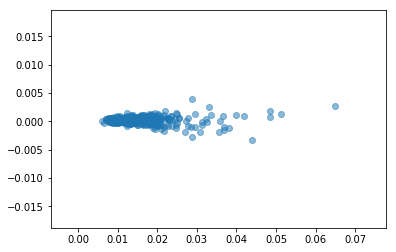

In [16]:
plt.scatter(std_l,rend_l, alpha=0.5)

In [17]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*20
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) optimization (n=2) [a la main]

[298 199]
[0.02883616 0.01237531] [0.00400682 0.00145298]


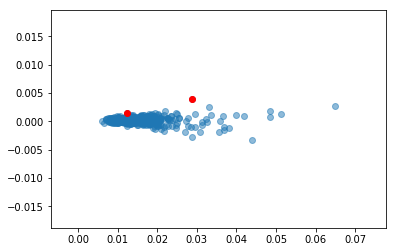

In [18]:
res = np.argsort(classement)[-2:]
print(res)
print(std_l[res],rend_l[res])

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

[298 199] [0.00400682 0.00145298]
rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]


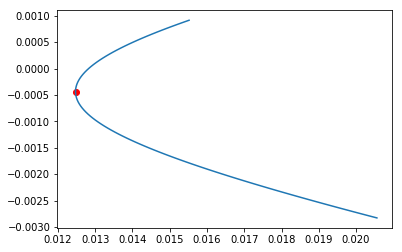

In [19]:
print(res,rend_l[res])

mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Optimization (n=3) [a la main]

[  9 298 199]


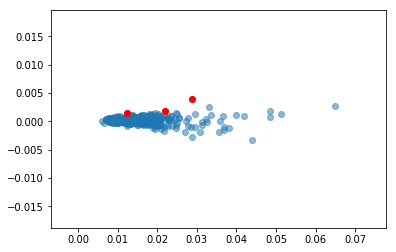

In [20]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [21]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: 0.0013752421118060048 & volatilité: 0.009402974296184809 -> poid: [0.43434343 0.24242424 0.32323232]


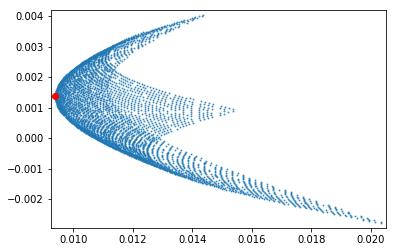

In [22]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [23]:
# u = [1, ..., 1]

In [24]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.36105675, 0.63894325])

rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]
rend: -0.0004369427732414565 & volatilité: 0.01247204980519934 -> poid: [0.36105675 0.63894325]


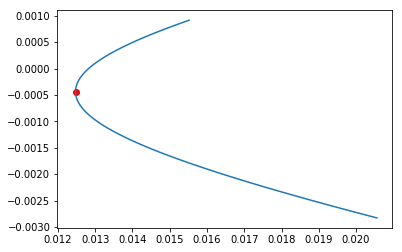

In [25]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)

plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [26]:
res = np.argsort(classement)[-20:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([ 0.08704274,  0.09728469,  0.00947826,  0.05265938,  0.15559307,
        0.08348779,  0.047225  ,  0.03282411,  0.03037133,  0.079817  ,
        0.04372638,  0.06790757,  0.03176922, -0.00976116,  0.02831892,
        0.03109128,  0.0099206 ,  0.05254024,  0.02367971,  0.04502386])

In [27]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

rend: 0.001281212247538031 & volatilité: 0.003132456198685023 -> poid: [ 0.08704274  0.09728469  0.00947826  0.05265938  0.15559307  0.08348779
  0.047225    0.03282411  0.03037133  0.079817    0.04372638  0.06790757
  0.03176922 -0.00976116  0.02831892  0.03109128  0.0099206   0.05254024
  0.02367971  0.04502386]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: -0.0004369427732414565 & volatilité: 0.01247204980519934
[3] rend: 0.0013616085350306652 & volatilité: 0.00940280794751328
[4] rend: 0.0035259702482595637 & volatilité: 0.008324506342767189
[5] rend: 0.003051527610881727 & volatilité: 0.008085443144501384
[6] rend: 0.0035378697852437575 & volatilité: 0.0072120888349417635
[7] rend: 0.0036305010163024177 & volatilité: 0.0068190576276451744
[8] rend: 0.004035969276946628 & volatilité: 0.006672655126413626
[9] rend: 0.0036163754421560898 & volatilité: 0.006029403934690524
[10] rend: 0.004126003114655756 & volatilité: 0.005486041362762635
[11] rend: 0.0036344997303511288 & volatilité: 0.005191767298310166
[12] rend: 0.0037330633063125695 & volatilité: 0.005042904550385888
[13] rend: 0.0035306252703036114 & volatilité: 0.004981714267835048
[14] rend: 0.0030751499873621145 & volatilité: 0.004732471316799911
[15] rend: 0.002634373677759434 & volatilité: 0.004427261298138719
[16] rend: 0.0015254310854671514 & volatilité: 0.0037427843

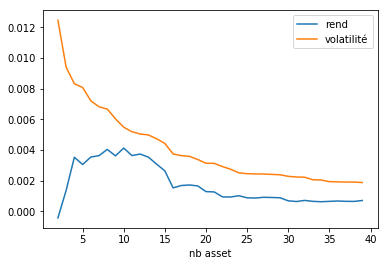

In [28]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation

In [29]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [30]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [31]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [32]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[39] rend: -0.002818750582300833 & volatilité: 0.02050535048138912


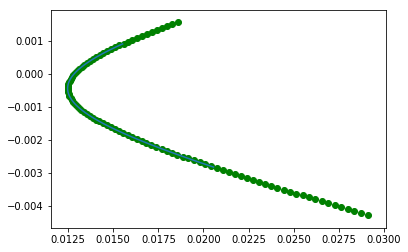

In [33]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=40

In [48]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])

In [35]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
w_20

array([0.09980039, 0.08134352, 0.0286253 , 0.05913016, 0.12603823,
       0.07042426, 0.12444008, 0.05640663, 0.01875437, 0.06064726,
       0.02958301, 0.06343675, 0.07800757, 0.00166196, 0.10170051])

rend: 0.003141414141414141 & volatilité: 0.004461577568650825


array([0.09696645, 0.07848591, 0.02623178, 0.06019571, 0.12254642,
       0.07360216, 0.12261855, 0.06061177, 0.02098976, 0.06346802,
       0.02784649, 0.06601166, 0.0785748 , 0.00013707, 0.10171346])

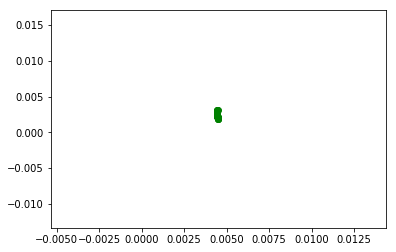

In [68]:
target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = get_w(mat_return, i)
    if all(element > 0  for element in w):
        W=w
        variance, std, rend = sharpe(w, mat_return)
        if std < rend:
            best = f"rend: {rend} & volatilité: {std}"
            plt.scatter(std, rend, c="red")
        else:
            best = f"rend: {rend} & volatilité: {std}"
            plt.scatter(std, rend, c="green")
        
print(best)
W

In [38]:
def check_type(list_id):
    df_asset = req.get_asset()[["ASSET_DATABASE_ID", "TYPE"]]
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["TYPE"].values
    print(np.unique(pf_type, return_counts=True))
    return np.sum(pf_type == "STOCK")/pf_type.shape[0]
    
    
check_type(l_id[res])

(array(['FUND', 'INDEX', 'STOCK'], dtype=object), array([ 3,  2, 35]))


0.875

In [70]:
def get_amout(w, list_id, list_nav, solde= 1000000):
    start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
    price = list_nav.loc[list_nav.index == start]
    nb_actif= []
    for i in range(len(list_id)):
        nb = (solde*w[i])//price[list_id[i]].values[0]
        print(f"montant: {(solde*w[i])}, prix: {price[list_id[i]].values[0]}, nb: {nb}")
        nb_actif.append(nb)
    return np.array(nb_actif)
    
    
get_amout(W, l_id[res], list_nav)

montant: 96966.45390068942, prix: 0.875, nb: 110818.0
montant: 78485.91274535452, prix: 4.295, nb: 18273.0
montant: 26231.777635590654, prix: 19.65, nb: 1334.0
montant: 60195.71058169733, prix: 27.39, nb: 2197.0
montant: 122546.41661118492, prix: 21.65, nb: 5660.0
montant: 73602.16433046179, prix: 46.81, nb: 1572.0
montant: 122618.54764391102, prix: 9.77, nb: 12550.0
montant: 60611.76649102597, prix: 8.785, nb: 6899.0
montant: 20989.75910367581, prix: 0.0172, nb: 1220334.0
montant: 63468.01889712912, prix: 8.03, nb: 7903.0
montant: 27846.491260918974, prix: 0.42, nb: 66301.0
montant: 66011.65673859527, prix: 0.06, nb: 1100194.0
montant: 78574.80188738885, prix: 20.9896, nb: 3743.0
montant: 137.0659230930521, prix: nan, nb: nan
montant: 101713.45624928299, prix: 145.95, nb: 696.0


array([1.108180e+05, 1.827300e+04, 1.334000e+03, 2.197000e+03,
       5.660000e+03, 1.572000e+03, 1.255000e+04, 6.899000e+03,
       1.220334e+06, 7.903000e+03, 6.630100e+04, 1.100194e+06,
       3.743000e+03,          nan, 6.960000e+02])

## Porte-Feuille

In [42]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": [
            {
            "asset": {
                "asset": 2024,
                "quantity": 2
                }
            }
        ]
    }
}
pp = json.dumps(new_portfolio)

In [43]:
req.push(pp).text

''

In [44]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{"2016-06-01":[{"asset":{"asset":2024,"quantity":2.0}}]}}'